# Pilot Points Setup

Up until this point we have been calibrating the Freyberg model with only two parameters (`hk1` and `rch0`). These parameters' values are applied to the entire model domain, not accounting for potential spatial heterogeneity. This is a pretty coarse parameterisation approach.

In the past (i.e. the dark ages), parameter spatial characterization was often implemented using zones of piece-wise constant values. Such parameterisation schemes were often subjective, inflexible and provide coarse representations of how physical properties vary in space. Parameterisation schemes that rely solely on zones should be treated with caution and/or an understanding of the inherent structural error which they bring with them. We will not be using zone-based approaches in these tutorials.

Methods of spatial parameterisation based on pilot points reduce these issues. With pilot point based parameterisation, parameter values are assigned to a set of points throughout the model domain rather than the model grid directly. Property values are then assigned to the model grid through spatial interpolation from pilot points. This results in a smooth spatially varying property field. 

This introduces the need for a model pre-processor that handles interpolation from pilot points to the model grid (and assigns values to model input files). The PLPROC suite of software is one option. `pyEMU` includes python-based alternatives.

In this notebook we will employ pilot points to parameterize hydraulic conductivity in the Freyberg model discussed in previous tutorials. Here, we will be adding pilot points to an existing pest setup. This may be usefull in some cases, specially when dealing with legacy models. However, it may be a non-standard workflow.  The approach demonstrated in this notebook is __not__ the recommended approach to construct a highly-parameterized PEST setup with `pyEMU`. We are using it here simply to maintain a coherent narative throughout the `Part1` tutorial notebooks. See `Part2` of the GMDSI Notebooks for a tutorial on `pyemu.PstFrom` instead. 
 
### Admin
We have provided some pre-cooked PEST dataset files, wraped around the modified Freyberg model. This is the same dataset introduced in the "freyberg_pest_setup" and subsequent notebooks. 

The functions in the next cell import required dependencies and prepare a folder for you. This folder contains the model files and a preliminary PEST setup. Run the cells, then inspect the new folder named "freyberg_mf6" which has been created in your tutorial directory. (Just press `shift+enter` to run the cells). 

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst


Load the PEST control file:

In [3]:
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg.pst'))

Before we get started, just run PEST++ to repeat the last tutorial. We do this to have access to files for comparison.

As we did in the last tutorial, set `rch0` parameter transform to `log`:

In [4]:
#update paramter transform
par = pst.parameter_data
par.loc['rch0', 'partrans'] = 'log'

Assign weights to the `gage-1` observations during the calibration period:

In [5]:
obs = pst.observation_data
obs.loc[(obs.obgnme=="gage-1") & (obs['gage-1'].astype(float)<=3804.5), "weight"] = 0.05

## Add pilot points

OK, we currently have the model and PEST(++) setup introduced in the "freyberg k, r and fluxobs" tutorial. We have non-zero weighted head and flux target observations. We have `hk1` and `rch0` (hydraulic conductivity and recharge during the calibration period) set as adjustable parameters.

We will now setup pilot points as a parameterisation device for hydraulic conductivity. There are multiple approaches to implementing pilot points with PEST++. In this class, we will use some kick-ass `pyemu` sweetness.

The followng section relies on the use of `flopy`. Functionalitly for setting up pilot points in `pyemu` is limited to MODFLOW models. If you are using other groundwater modelling software, you will need to construct them yourself or check whether it is supported by PLPROC.

Start by loading the model using `flopy`.

In [6]:
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d, verbosity_level=0) #modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=[])
gwf= sim.get_model()


### Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IDOMAIN` such that all active cells are in the same interpolation zone.

In [7]:
ibound=gwf.dis.idomain.get_data()

### Get the model spatial reference

We need to get information on the model grid so that `pyemu` can set up interpolation from pilot points to the model cells:

In [8]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


We are going to use a `pyemu` helper function to setup pilot points are cell centers for active cells:

In [9]:
# we want hk pilot points in the top layer...
prefix_dict = {0:["hk"]} 
df_pp = pyemu.pp_utils.setup_pilotpoints_grid(sr=sr,  # model spatial reference
                                              ibound=ibound, # to which cells to setup ppoints
                                              prefix_dict=prefix_dict, #prefix to add to parameter names
                                              pp_dir=tmp_d, 
                                              tpl_dir=tmp_d, 
                                              every_n_cell=5) # pilot point spacing
pp_file = os.path.join(tmp_d,"hkpp.dat")
assert os.path.exists(pp_file)

Let's look at ``df_pp`` - it has a lot of useful info. As you can see, `pyemu` has associated pilot points, to their coordinates, zone and (what will become) parameter data as well as an associated `*.tpl` file. 

In [10]:
df_pp.head()

,name,x,y,zone,parval1,k,i,j,parnme,tpl,tpl_filename,pp_filename,pargp,partrans,parchglim,parlbnd,parubnd,scale,offset,dercom
0,pp_0000,625.0,9375.0,1.0,1.0,0,2,2,hk_i:2_j:2_zone:1.0,~ hk_i:2_j:2_zone:1.0 ~,freyberg_mf6\hkpp.dat.tpl,freyberg_mf6\hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
1,pp_0001,1875.0,9375.0,1.0,1.0,0,2,7,hk_i:2_j:7_zone:1.0,~ hk_i:2_j:7_zone:1.0 ~,freyberg_mf6\hkpp.dat.tpl,freyberg_mf6\hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
2,pp_0002,3125.0,9375.0,1.0,1.0,0,2,12,hk_i:2_j:12_zone:1.0,~ hk_i:2_j:12_zone:1.0 ~,freyberg_mf6\hkpp.dat.tpl,freyberg_mf6\hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
3,pp_0003,4375.0,9375.0,1.0,1.0,0,2,17,hk_i:2_j:17_zone:1.0,~ hk_i:2_j:17_zone:1.0 ~,freyberg_mf6\hkpp.dat.tpl,freyberg_mf6\hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
4,pp_0004,625.0,8125.0,1.0,1.0,0,7,2,hk_i:7_j:2_zone:1.0,~ hk_i:7_j:2_zone:1.0 ~,freyberg_mf6\hkpp.dat.tpl,freyberg_mf6\hkpp.dat,hk,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1


So cool, we now defined pilot points as a set of spatially distributed parameters...but how do go from pilot points to the model input HK array? Answer: geostatistics.  

We need to calculate the geostatistical factors (weights) used to form the interpolated value for the HK value at each model cell - its a spatially-weighted combination of pilot point values

### Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

From _PEST Groundwater Data Utilities Part A: Overview_ page 43, there are 4 acceptable variogram types:

 1. *Spherical*  
 $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
 $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
 $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
 $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
 
 4. *Power*  
 $\gamma\left(h\right)=c\times h^a$
     
 The number refers to `VARTYPE`. 
 
 `BEARING` and `ANISOTROPY` only apply if there is a principal direction of anisotropy. 
 
 $h$ is the separation distance, and $a$ is the range, expressed with the `A` parameter.

### First, let's create ``variogram`` and ``GeoStruct`` objects.  

These describe how HK varies spatially. 

(0.0, 2.0)

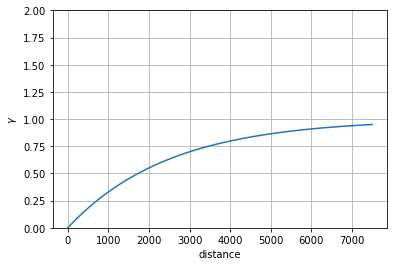

In [11]:
v = pyemu.geostats.ExpVario(contribution=1.0, a=2500, anisotropy=1, bearing=0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
ax.set_ylim(0,2.0)

Now, let's get an ``OrdinaryKrige`` object, which needs the ``GeoStruct`` as well as the x, y, and name of the pilot point locations (which happens to be in that really cool ``df_pp`` instance)

In [12]:
ok = pyemu.geostats.OrdinaryKrige(gs,df_pp)

Once the ``OrdinaryKrige`` is created, we need to calculate the geostatistical interpolation factors for each model cell.  We do this with the ``.calc_factors_grid()`` method: it needs to know about the model's spatial orientation and also accepts some optional arguments:

In [13]:
df = ok.calc_factors_grid(sr,var_filename="freyberg.var.ref", minpts_interp=1,maxpts_interp=10, )

starting interp point loop for 800 points
took 2.243637 seconds


One of the really cool things about geostatistics is that it gives you both the interpolation (factors), but also gives you the uncertainty in the areas between control (pilot) points.  Above, we wrote this uncertainty information to an array that has the same rows and cols as the model grid - this array is very useful for understanding the function of the variogram.

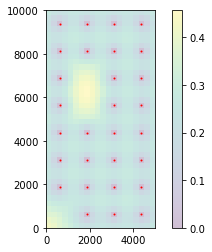

In [14]:
arr_var = np.loadtxt("freyberg.var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=sr.get_extent(),alpha=0.25)
plt.colorbar(p)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='r');

We see that at the pilot point locations (red dots), the uncertainty in the geostats is minimal...as expected. The color scale is uncertainty. It increaes with distance to pilot points.

The call to ``.calc_factors_grid()`` also returns a ``DataFrame`` which has useful info - lets look:

In [15]:
df.head()

,x,y,idist,inames,ifacts,err_var
0,125.0,9875.0,"[707.1067811865476, 1820.0274723201296, 1820.0274723201296, 3041.38126514911, 3041.38126514911, ...","[pp_0000, pp_0001, pp_0004, pp_0002, pp_0008, pp_0009, pp_0003, pp_0011]","[0.7115647141955732, 0.05543091711738018, 0.05508798036086901, 0.025682400127502423, 0.024000291...",0.265929
1,375.0,9875.0,"[559.0169943749474, 1581.1388300841897, 1767.7669529663688, 2795.084971874737, 3010.398644698074...","[pp_0000, pp_0001, pp_0004, pp_0002, pp_0008, pp_0003, pp_0009, pp_0011]","[0.7490092682560686, 0.08732922533848612, 0.02020301904234272, 0.02561452860632063, 0.0156138931...",0.224504
2,625.0,9875.0,"[500.0, 1346.291201783626, 2549.5097567963926, 3000.0, 3783.186487605389, 3905.124837953327, 413...","[pp_0000, pp_0001, pp_0002, pp_0008, pp_0003, pp_0009, pp_0007]","[0.733366868970951, 0.1474764818839198, 0.026819066995212287, 0.02745521210217107, 0.03173572568...",0.203108
3,875.0,9875.0,"[559.0169943749474, 1118.033988749895, 2304.886114323222, 3010.398644698074, 3535.5339059327375,...","[pp_0000, pp_0001, pp_0002, pp_0008, pp_0003, pp_0009, pp_0007]","[0.6507305170900195, 0.24331180973671632, 0.03076096113076711, 0.019279616911883093, 0.029544927...",0.223952
4,1125.0,9875.0,"[707.1067811865476, 901.3878188659974, 2061.5528128088304, 3041.38126514911, 3288.2366094914764,...","[pp_0000, pp_0001, pp_0002, pp_0008, pp_0003, pp_0009, pp_0007]","[0.5278099528020117, 0.3655027695342027, 0.03913966373758959, 0.015225341704513657, 0.0299304658...",0.249281


We see that there is one row for each model cell, and for each row, we see the distance, names, and weight for the "nearby" pilot points.  The interpolated value for cells that have a pilot point at their center only need one weight - 1.0 - and one pilot point.  Other cells are weighted combinations of pilot points. 

### Back to linking pilot points to grid values

Now we need to save the factors (weights) to a special file that we will use later to quickly generate a new HK array from a set of pilot point values:

In [16]:
ok.to_grid_factors_file(pp_file+".fac")

Just for demo purposes, lets generate ``random`` pilot point values and run them through the factors to see what the ``hk`` array looks like

In [17]:
# generate random values
df_pp.loc[:,"parval1"] = np.random.random(df_pp.shape[0])
# save a pilot points file
pyemu.pp_utils.write_pp_file(pp_file,df_pp)

In [18]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.geostats.fac2real(pp_file, factors_file=pp_file+".fac",out_file=None, )

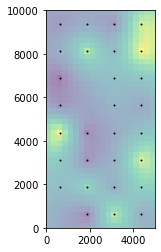

In [19]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=sr.get_extent(),alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='k')

What happens if you recalculate the factors using one point for every cell? Change ``max_interp_pts`` to 1 in the ``calc_factors_grid()`` and rerun these cells.

### (Foreshadowng) An aside on geostatistics and covariance matrices

The ``GeoStruct`` object above was used to interpolate from pilot point locations to each node in the grid.  But this same ``GoeStruct`` also has an important information regarding how the pilot points are related to each other spatially---that is, the ``GeoStruct`` object implies a covariance matrix.  Let's form that matrix 

In [20]:
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)

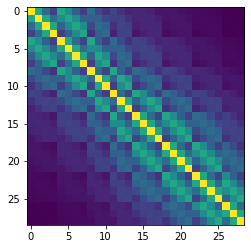

In [21]:
plt.imshow(cov.x)

In [22]:
cov.to_dataframe().head()

,hk_i:2_j:2_zone:1.0,hk_i:2_j:7_zone:1.0,hk_i:2_j:12_zone:1.0,hk_i:2_j:17_zone:1.0,hk_i:7_j:2_zone:1.0,hk_i:7_j:7_zone:1.0,hk_i:7_j:12_zone:1.0,hk_i:7_j:17_zone:1.0,hk_i:12_j:2_zone:1.0,hk_i:12_j:12_zone:1.0,...,hk_i:27_j:7_zone:1.0,hk_i:27_j:12_zone:1.0,hk_i:27_j:17_zone:1.0,hk_i:32_j:2_zone:1.0,hk_i:32_j:7_zone:1.0,hk_i:32_j:12_zone:1.0,hk_i:32_j:17_zone:1.0,hk_i:37_j:7_zone:1.0,hk_i:37_j:12_zone:1.0,hk_i:37_j:17_zone:1.0
hk_i:2_j:2_zone:1.0,1.000000,0.606531,0.367879,0.223130,0.606531,0.493069,0.326922,0.205741,0.367879,0.243117,...,0.078120,0.067706,0.054178,0.049787,0.047769,0.042329,0.034941,0.029143,0.026251,0.022195
hk_i:2_j:7_zone:1.0,0.606531,1.000000,0.606531,0.367879,0.493069,0.606531,0.493069,0.326922,0.326922,0.326922,...,0.082085,0.078120,0.067706,0.047769,0.049787,0.047769,0.042329,0.030197,0.029143,0.026251
hk_i:2_j:12_zone:1.0,0.367879,0.606531,1.000000,0.606531,0.326922,0.493069,0.606531,0.493069,0.243117,0.367879,...,0.078120,0.082085,0.078120,0.042329,0.047769,0.049787,0.047769,0.029143,0.030197,0.029143
hk_i:2_j:17_zone:1.0,0.223130,0.367879,0.606531,1.000000,0.205741,0.326922,0.493069,0.606531,0.164841,0.326922,...,0.067706,0.078120,0.082085,0.034941,0.042329,0.047769,0.049787,0.026251,0.029143,0.030197
hk_i:7_j:2_zone:1.0,0.606531,0.493069,0.326922,0.205741,1.000000,0.606531,0.367879,0.223130,0.606531,0.326922,...,0.127256,0.106878,0.082085,0.082085,0.078120,0.067706,0.054178,0.047769,0.042329,0.034941


What do these numbers mean?  Why should you care?  Well, this covariance matrix plays an important role in uncertainty quantification, as well as in governing the way pilot point parameters are adjusted during calibration. We will return to these toics in future tutorials.

 Now back to setting up our pilot points and control file.

## Build a control file using these pilot points

There's a fair amount of support in pyemu for building control files and setting PEST inferfaces.  Here we will only briefly touch on some of the basic components.  If you have created template files and instruction files, and have used our proposed naming convention, then you can quickly generate a control file using the following call

First let's just get rid of the existing `hk1` parameter (for simplicity, we are simply going to replace it with the pilot point parameters):

In [23]:
pst.parameter_data
hk_parval, hkub, hklb = pst.parameter_data.loc['hk1', ['parval1','parlbnd','parubnd']]
hk_parval, hkub, hklb

(5.0, 0.05, 500.0)

In [24]:
pst.drop_parameters(tpl_file=os.path.join(tmp_d,'freyberg6.npf_k_layer1.txt.tpl'), pst_path='.', )
# remove the .tpl file for tidyness
os.remove(os.path.join(tmp_d,'freyberg6.npf_k_layer1.txt.tpl') )
# check the difference
pst.parameter_data

1 pars dropped from template file freyberg_mf6\freyberg6.npf_k_layer1.txt.tpl


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,extra,dercom
parnme,,,,,,,,,,,
ne1,ne1,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,NaN,1.0
rch0,rch0,log,factor,1.00,0.500,2.00,rch,1.0,0.0,NaN,1.0
rch1,rch1,fixed,factor,1.00,0.500,2.00,rch,1.0,0.0,NaN,1.0


Now add in the pilot point parameters by reading the `*.tpl` file we created earlier:

In [25]:
par_pp = pst.add_parameters(os.path.join(tmp_d,'hkpp.dat.tpl'), pst_path='.' )
par_pp.head()

29 pars added from template file .\hkpp.dat.tpl


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk_i:2_j:12_zone:1.0,hk_i:2_j:12_zone:1.0,log,factor,0.130156,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk_i:37_j:12_zone:1.0,hk_i:37_j:12_zone:1.0,log,factor,0.740206,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk_i:17_j:2_zone:1.0,hk_i:17_j:2_zone:1.0,log,factor,0.122270,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk_i:37_j:17_zone:1.0,hk_i:37_j:17_zone:1.0,log,factor,0.270021,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk_i:17_j:12_zone:1.0,hk_i:17_j:12_zone:1.0,log,factor,0.344278,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


Update the pilot point parameter data:

In [26]:
pst.parameter_data.loc[par_pp.parnme, ['parval1','parlbnd','parubnd', 'pargp']] = hk_parval, hkub, hklb, 'hk1'
pst.parameter_data.head(6)

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,extra,dercom
ne1,ne1,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,NaN,1.0
rch0,rch0,log,factor,1.00,0.500,2.00,rch,1.0,0.0,NaN,1.0
rch1,rch1,fixed,factor,1.00,0.500,2.00,rch,1.0,0.0,NaN,1.0
hk_i:2_j:12_zone:1.0,hk_i:2_j:12_zone:1.0,log,factor,5.00,0.050,500.00,hk1,1.0,0.0,NaN,1.0
hk_i:37_j:12_zone:1.0,hk_i:37_j:12_zone:1.0,log,factor,5.00,0.050,500.00,hk1,1.0,0.0,NaN,1.0
hk_i:17_j:2_zone:1.0,hk_i:17_j:2_zone:1.0,log,factor,5.00,0.050,500.00,hk1,1.0,0.0,NaN,1.0


## Model Pre-Processor
We have aded the pilot point parameters to the control file, but still need to add a pre-processor to the "model run" bacth/script file. Currently, it only runs MODFLOW and MODPATH. We need an additional step beforehand to interpolate values fmor pilot points to model grid and assign values to model input files (as we did earlier.)

Easy enough, let's write a python script file that implements the same steps we did above, as well as run MODFLOW and MODPATH.

Write amodel run script, with a pre-processor:

In [27]:
with open(os.path.join(tmp_d, "forward_run.py"),'w') as f:
    #add imports
    f.write("import os\nimport shutil\nimport pandas as pd\nimport numpy as np\nimport pyemu\nimport flopy\n")
    # preprocess pilot points to grid
    f.write("pp_file = 'hkpp.dat'\n")
    f.write("hk_arr = pyemu.geostats.fac2real(pp_file, factors_file=pp_file+'.fac',out_file='freyberg6.npf_k_layer1.txt')\n")
    # run MF6 and MP7
    f.write("pyemu.os_utils.run('mf6')\n")
    f.write("pyemu.os_utils.run('mp7 freyberg_mp.mpsim')\n")

And then make sure to update the `Pst` to reflect the new "model run" command:

In [28]:
pst.model_command 

['runmodel.bat']

In [29]:
pst.model_command = ['python forward_run.py']
pst.model_command 

['python forward_run.py']

Re-write and run PEST++:

In [30]:
pst.control_data.noptmax = 0 

In [31]:
pst.write(os.path.join(tmp_d, 'freyberg_pp.pst'))

noptmax:0, npar_adj:30, nnz_obs:30


Watch the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [32]:
pyemu.os_utils.run("pestpp-glm freyberg_pp.pst", cwd=tmp_d)

Check if it completed sucessfully:

In [33]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg_pp.pst'))
assert pst.phi

Good to go. We will pick up from here in the next tutorial notebook.